# Data Extraction

Built through **PDF Plumber** and depends on structure of the company's transcript releases - intuitive to adapt code. Consider the data in its raw form, consisting of text and \n (new lines). Normally, these are consistent for companies and therefore straightforward to implement rules to extract **dates, names,** etc. depending on where they are positioned in the format of the transcript.

For example, the dates for the below transcript form follow from 'Earnings Call' in the title. By finding the index of where that title ends: 

**date_idx = txt.find('EVENT DATE/TIME: ') + len('EVENT DATE/TIME: ')** 

We can find a range that encompasses the title and use split() to identify the month, day, year, etc.

In [ ]:
import os
import pdfplumber

In [ ]:
def transcript_convert(ticker):
    path = '...Transcripts/ALK'
    # path = os.path.join(*paths, ticker)
    pdf_list = [x for x in os.listdir(path) if x[-4:] == '.pdf']
    print(pdf_list)
    columns = ['particip', 'qna', 'transcript', 'date', 'company']
    data = pd.DataFrame(columns=columns)
    for f in pdf_list:
        found_start = False
        out = ''
        with pdfplumber.open(os.path.join(path, f)) as pdf:

            for i,v in enumerate(pdf.pages):
                curr_page = pdf.pages[i]
                txt = curr_page.extract_text()

                if i == 0:
                    if txt.find(ticker + ' -') != -1:
                        dt_idx = txt.find(ticker + ' -')
                        qt_txt = txt[dt_idx:].split('\n')
                        qt_txt = [x for x in qt_txt if x != ' '][0].strip(ticker + ' -')  # remove ' '
                    else:
                        qt_txt = [x for x in txt.split('\n') if 'Earnings' in x][0]
                    quarter = qt_txt.split()[0]
                    year = qt_txt.split()[1]
                    date_idx = txt.find('EVENT DATE/TIME: ') + len('EVENT DATE/TIME: ')
                    date_idx_end = date_idx + 50  # static character count for length of date
                    date = parse(txt[date_idx:date_idx_end].split('\n')[0]).strftime('%m-%d-%y')
                    comp_name = qt_txt.split(' Earnings Call')[0][qt_txt.split(' Earnings Call')[0].find(year)+ len(year) + 1:]

                elif i == 1:
                    corp_idx = txt.find('CORPORATE PARTICIPANTS')+len('CORPORATE PARTICIPANTS\n')
                    corp_idx_end = txt.find('\nCONFERENCE CALL PARTICIPANTS')
                    conf_idx = txt.find('CONFERENCE CALL PARTICIPANTS') + len('CONFERENCE CALL PARTICIPANTS\n')
                    conf_idx_end = txt.find('PRESENTATION')
                    corp_txt = txt[corp_idx:corp_idx_end].split('\n')
                    corp_name = [x.split(comp_name.split()[0])[0] for x in corp_txt]
                    corp_name = [x.strip() for x in corp_name if x.strip() != '']
                    corp_speaker1 = corp_name
                    corp_speaker2 = [x.split()[0] + ' ' + x.split()[1] for x in corp_txt if len(x.split()) >= 2]
                    corp_speaker3 = [x.split()[0] + ' ' + x.split()[2] for x in corp_txt if
                                     len(x.split()) >= 3]
                    corp_speaker4 = [x.split()[0] + ' ' + x.split()[1] + ' ' + x.split()[2] for x in corp_txt if
                                     len(x.split()) >= 3]

                    conf_txt = txt[conf_idx:conf_idx_end].split('\n')
                    conf_speaker1 = [x.split()[0] + ' ' + x.split()[1] for x in conf_txt if len(x.split()) >= 2]
                    conf_speaker2 = [x.split()[0] + ' ' + x.split()[2] for x in conf_txt if len(x.split()) >= 3]    # accounts for speakers with middle name
                    conf_speaker3 = [x.split()[0] + ' ' + x.split()[1] + ' ' + x.split()[2] for x in conf_txt if len(x.split()) >=3]    # accounts for speakers with middle name

                    speaker_list = corp_speaker1 + corp_speaker2 + corp_speaker3 + corp_speaker4 + conf_speaker1 + conf_speaker2 + conf_speaker3

                    columns = ['corp_particip','conf_particip']
                    df_speaker = pd.DataFrame(columns=columns)
                    corp_list = corp_speaker1 + corp_speaker2 + corp_speaker3 + corp_speaker4
                    conf_list = conf_speaker1 + conf_speaker2 + conf_speaker3
                    df_speaker['corp_particip'] = corp_list + (max(len(corp_list), len(conf_list)) -len(corp_list)) * ['']
                    df_speaker['conf_particip'] = conf_list + (max(len(corp_list), len(conf_list)) -len(conf_list)) * ['']
                    df_speaker.to_csv(os.path.join(path, ticker + '_' + date + '_speakers.csv'), index=False)

                # remove footer
                if i != 0 and i != len(pdf.pages)-1:
                    beginning_idx = txt.find('Earnings Call')+len('Earnings Call\n')
                    pg_num_idx = txt.find('\n' + str(i + 1))
                    txt = txt[beginning_idx:pg_num_idx]

                # remove disclaimer
                elif i ==len(pdf.pages)-1:  # if last page remove disclaimer
                    beginning_idx = txt.find('Earnings Call')+len('Earnings Call\n')
                    dis_idx = txt.find('DISCLAIMER')
                    txt = txt[beginning_idx:dis_idx]

                # write to file
                if found_start == True:
                    out = out+txt

                elif txt.find('PRESENTATION') != -1 and found_start == False:
                    found_start = True
                    start_idx = txt.find('PRESENTATION')+len('PRESENTATION\n')
                    out = out+txt[start_idx:]

        columns = ['particip', 'qna', 'transcript', 'date', 'company']
        df = pd.DataFrame(columns=columns)
        speaker = ''
        content = ''
        qna_start_j = 1000  # initialize
        j = 0
        for line in out.split('\n'):

            if line.find('QUESTIONS AND ANSWERS') != -1:
                qna_start_j = j + 2
            if len(line.split()) == 1:
                find_speaker = [x for x in ['Operator'] if (x in line)]
            else:
                find_speaker = [x for x in speaker_list if (x + ' -' in line)]  # + ' -'

            if find_speaker == []:
                content = content + ' ' + line
            else:
                if speaker != '':
                    if speaker in corp_list:
                        df.loc[j] = [speaker, 0, content, date, ticker]
                    else:
                        df.loc[j] = [speaker, 1, content, date, ticker]
                    content = ''
                    j += 1

                speaker = find_speaker[0]

        print(pdf.pages[0].extract_text())
        data = data.append(df)

    data.to_csv(os.path.join(path, ticker + '.csv'), index=False)
    print('converted: ' + os.path.join(path, ticker + '.csv'))

**Result is a file of multiple transcripts - by speaker, whether company personnel or external and date of the earnings call.**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [4]:
data = pd.read_csv(root_folder+'/Transcripts_test.csv')
data['date'] = pd.Series(pd.to_datetime(data['date'], format='%m-%d-%y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   particip    1058 non-null   object        
 1   qna         1058 non-null   int64         
 2   transcript  1058 non-null   object        
 3   date        1058 non-null   datetime64[ns]
 4   company     1058 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 41.5+ KB


# Data Processing and Exploratory Analysis

Clean text using regex and filter dataframe as appropriate, for example by age, by date, by topics, etc.

In [5]:
def clean(text):
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t', '', str(text))
    # removing new line characters
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    # removing apostrophes
    text = re.sub("'s", '', str(text))
    # removing hyphens
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    # removing quotation marks
    text = re.sub('\"', '', str(text))
    # removing salutations
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))

    return text

In [6]:
# preprocessing speeches
data['Transcript_clean'] = data['transcript'].apply(clean)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   particip          1058 non-null   object        
 1   qna               1058 non-null   int64         
 2   transcript        1058 non-null   object        
 3   date              1058 non-null   datetime64[ns]
 4   company           1058 non-null   object        
 5   Transcript_clean  1058 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 49.7+ KB


**Considering a subset of data - namely only company personnel.**

In [46]:
data_subset = data[data['qna'] == 0]
data_subset = data_subset.drop(['particip'], axis=1)
# data_subset = data_subset.groupby(['date'])['Transcript_clean'].apply(' '.join).reset_index()
data_subset['year'] = pd.DatetimeIndex(data_subset['date']).year
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693 entries, 0 to 1057
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   qna               693 non-null    int64         
 1   transcript        693 non-null    object        
 2   date              693 non-null    datetime64[ns]
 3   company           693 non-null    object        
 4   Transcript_clean  693 non-null    object        
 5   year              693 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 37.9+ KB


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# Import the seaborn library, it is a powerful library for plotting and commonly used with matplotlib
import seaborn as sns
sns.set_style("white")
import random
from collections import Counter

import string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.summarization.textcleaner import split_sentences

from wordcloud import WordCloud

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
nltk.download('universal_tagset')

In [12]:
# Define some global variables for text processing
punc = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

In [20]:
def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text) #splitta i pezzi
    stopwords_x = [w for w in word_tokens if w in stopwords]
    
    return len(stopwords_x)

In [21]:
data_subset['text_sent_count'] = data_subset['Transcript_clean'].apply(lambda x : len(split_sentences(x)))
data_subset['text_word_count'] = data_subset['Transcript_clean'].apply(lambda x : len(x.split()))
data_subset['text_char_count'] = data_subset['Transcript_clean'].apply(lambda x : len(x.replace(" ","")))
data_subset['text_word_density'] = data_subset['text_word_count'] / (data_subset['text_char_count'] + 1)
data_subset['text_sent_density'] = data_subset['text_sent_count'] / (data_subset['text_word_count'] + 1)
data_subset['text_punc_count'] = data_subset['Transcript_clean'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
data_subset['text_stopw_count'] =  data_subset['Transcript_clean'].apply(lambda x : count_stopwords(x, stopwords))
data_subset['text_stopw_density'] = data_subset['text_stopw_count'] / (data_subset['text_word_count'] + 1)

In [22]:
print(data_subset[['text_word_count', 'text_char_count', 'text_word_density', 'text_punc_count']].head(5))

   text_word_count  text_char_count  text_word_density  text_punc_count
0             1653             8263           0.200024              241
1             1862             9687           0.192197              207
3              192              823           0.233010               33
4              119              548           0.216758               16
6              126              568           0.221441               14


In [23]:
data_subset[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,693.000000,693.000000,693.000000,693.000000,693.000000
mean,9.666667,186.976912,866.701299,85.028860,27.636364
std,12.304306,280.925405,1386.459402,116.484732,38.471451
min,1.000000,1.000000,3.000000,0.000000,1.000000
25%,3.000000,43.000000,194.000000,21.000000,7.000000
50%,6.000000,108.000000,471.000000,53.000000,16.000000
75%,11.000000,187.000000,821.000000,92.000000,29.000000
max,85.000000,1862.000000,9687.000000,732.000000,241.000000


In [34]:
quarters = data_subset['date'].unique()

In [24]:
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts',
             'text_sent_count': 'Sentence Count of Texts', 'sum_sent_count': 'Sentence Count of Summaries',
             'text_sent_density': 'Sentence Density of Texts', 'sum_sent_density': 'Sentence Density of Summaries',
             'text_stopw_count': 'Stopwords Count of Texts', 'sum_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 'text_unknown_count': 'Unknown words in Texts',
             'sum_unknown_count': 'Unknown words in Summaries',}

In [25]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    
   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows=1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))

    for i in range(nrows):
        for j in range(ncols):
            # If the column name is defined we plot it
            if plot_vars[i,j]!=None:
                if axes.ndim>1:
                    #Set the title
                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:
                    #Set the title
                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(False)

    f.tight_layout()
    plt.show() 


def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):

    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)

    for i in range(plot_vars.shape[1]):

        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        # For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])
        
    fig.tight_layout()

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

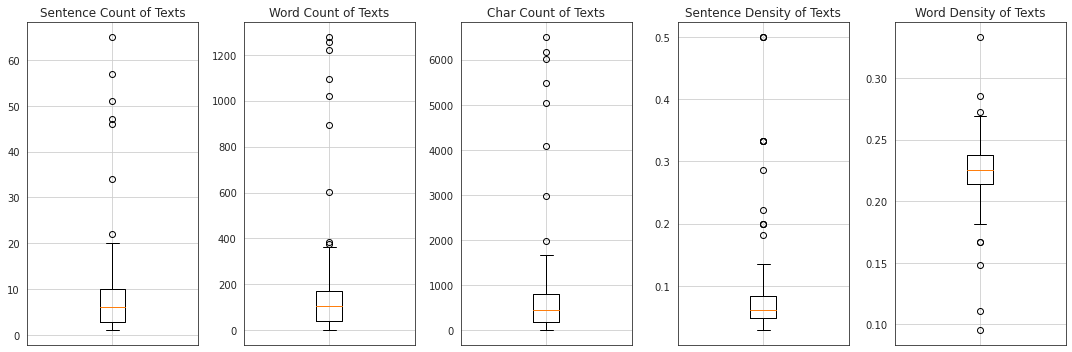

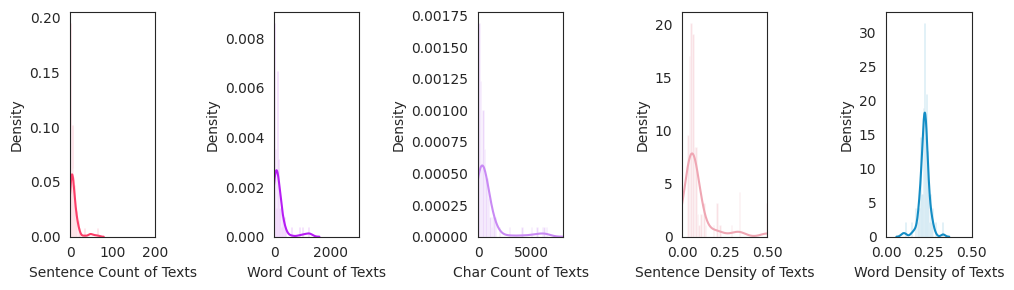

In [36]:
# Set financial quarter to look at 
per_quarter = data_subset[data_subset['date'] == quarters[2]]
# Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
plot_boxplots(per_quarter, plot_vars, labels_dict, figsize=(10,3))
plot_histograms(per_quarter, plot_vars, [200, 3000, 8000, 0.5, 0.5], labels_dict, figsize=(10,3))

# Part of Speech Tagging

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.

Tag Meaning English Examples:

*   ADJ, adjective: new, good, high, special, big, local
*   ADP,adposition: on, of, at, with, by, into, under
*   ADV, adverb: really, already, still, early, now
*   CONJ, conjunction: and, or, but, if, while, although
*   DET, determiner or article: the, a, some, most, every, no, which
*   NOUN, noun: year, home, costs, time, Africa
*   NUM,numeral: twenty-four, fourth, 1991, 14:24
*   PRT, particle: at, on, out, over per, that, up, with
*   PRON, pronoun: he, their, her, its, my, I, us
*   VERB, verb: is, say, told, given, playing, would
*   ., punctuation marks: . , ; !
*   X, othe: ersatz, esprit, dunno, gr8,

In [37]:
def get_pos_tags(sentences, tagset='universal'):

    #Create the Dataframe to store the count of tags
    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:
        # Extract the part of Speech tags in the sentence
        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = df.append(pos_tags, ignore_index=True).fillna(0)

    return df.astype(int)

In [44]:
# Identify the taggings for the text variable
news_text = data_subset['Transcript_clean'].values
df_text = get_pos_tags(news_text)

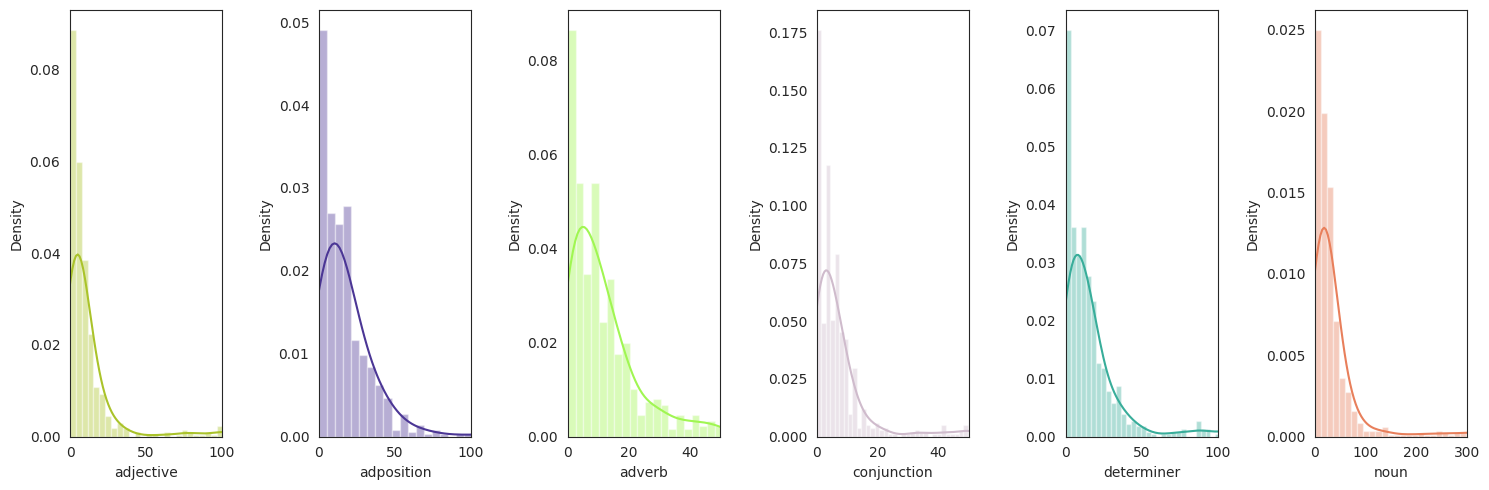

In [45]:
# Select the columns to plot: those related to pos taggings
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
# Plot a histograms of the variables 
plot_histograms(df_text, plot_vars, [100, 100, 50, 50, 100, 300], labels_dict, figsize=(15,5))

# Further Data Cleaning

Contraction mapping, text cleaning function, stemming and lemmatizer.

In [55]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [65]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [66]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [73]:
def plot_wordcloud(q):
    per_quarter = data_subset[data_subset['date'] == quarters[q]]
    cleaned_text = per_quarter['Transcript_clean'].apply(lambda x : text_cleaner(x))
    # Join the different processed texts together.
    long_string = ','.join(list(cleaned_text.values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

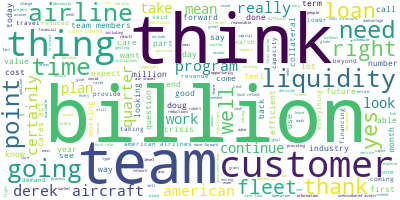

In [75]:
plot_wordcloud(4)

**Breaking this down by whole sentences to analyse the contents, context and grammatical structure through PoS.**

In [47]:
def sentences(text):
    # split sentences and questions
    text = re.split('[.?]', text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

In [51]:
# sentences
data_subset['sent'] = data_subset['Transcript_clean'].apply(sentences)

# create a dataframe containing sentences
df2 = pd.DataFrame(columns=['Sent', 'Year', 'Len'])

In [ ]:
row_list = []

for i in range(len(data_subset)):
    for sent in data_subset.loc[i, 'sent']:
        wordcount = len(sent.split())
        year = data_subset.loc[i, 'year']

        dict1 = {'Year': year, 'Sent': sent, 'Len': wordcount}
        row_list.append(dict1)

df2 = pd.DataFrame(row_list)
print(df2.head(10))

In [ ]:
import spacy
from spacy.matcher import Matcher
from spacy import displacy
# import visualise_spacy_tree
from IPython.display import Image, display
# load english language model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])

**Information Extraction – Finding Keywords and using Dependencies**
SpaCy’s Matcher class. It allows us to match a sequence of words based on certain patterns and using regex to find sentences that only contain keywords

In [ ]:
def prog_sent(text):
    patterns = [r'\b(?i)' + 'coronavirus' + r'\b',
                r'\b(?i)' + 'Covid-19' + r'\b',
                r'\b(?i)' + 'lockdown' + r'\b',
                r'\b(?i)' + 'vaccine' + r'\b', ]

    output = []
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag

In [ ]:
def all_schemes(text, check):
    schemes = []

    doc = nlp(text)

    # initiatives
    prog_list = ['coronavirus', 'Covid-19',
                 'lockdown', 'vaccine']

    # pattern to match initiatives names
    pattern = [{'POS': 'DET'},
               {'POS': 'PROPN', 'DEP': 'compound'},
               {'POS': 'PROPN', 'DEP': 'compound'},
               {'POS': 'PROPN', 'OP': '?'},
               {'POS': 'PROPN', 'OP': '?'},
               {'POS': 'PR OPN', 'OP': '?'},
               {'LOWER': {'IN': prog_list}, 'OP': '+'}
               ]

    if check == 0:
        # return blank list
        return schemes

    # Matcher class object
    matcher = Matcher(nlp.vocab)
    matcher.add("matching", [pattern])
    matches = matcher(doc)

    for i in range(0, len(matches)):

        # match: id, start, end
        start, end = matches[i][1], matches[i][2]

        if doc[start].pos_ == 'DET':
            start = start + 1

        # matched string
        span = str(doc[start:end])

        if (len(schemes) != 0) and (schemes[-1] in span):
            schemes[-1] = span
        else:
            schemes.append(span)

    return schemes

In [ ]:
def sent_subtree(text):
    # pattern match for schemes or initiatives
    patterns = [r'\b(?i)' + 'coronavirus' + r'\b',
                r'\b(?i)' + 'Covid-19' + r'\b',
                r'\b(?i)' + 'lockdown' + r'\b',
                r'\b(?i)' + 'vaccine' + r'\b']

    schemes = []
    doc = nlp(text)
    flag = 0
    # if no initiative present in sentence
    for pat in patterns:

        if re.search(pat, text) != None:
            flag = 1
            break

    if flag == 0:
        return schemes

    # iterating over sentence tokens
    for token in doc:

        for pat in patterns:

            # if we get a pattern match
            if re.search(pat, token.text) != None:

                word = ''
                # iterating over token subtree
                for node in token.subtree:
                    # only extract the proper nouns
                    if (node.pos_ == 'PROPN'):
                        word += node.text + ' '

                if len(word) != 0:
                    schemes.append(word)

    return schemes